# custom UCC ansatze for qiskit

In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter
import numpy as np

In [2]:
def custom_ansatz(operator, num_orbitals, p, q, initial_state):

    excitations = p+q

    # rotation angle
    angle = Parameter('θ')

    # creating the circuit
    circuit = QuantumCircuit(num_orbitals)

    # specifying the initial state (reference state)
    if initial_state != False:
        circuit.initialize(initial_state, range(num_orbitals))

    # klji
    for ladder in operator:

        # changing bases
        for q, op in zip(excitations, ladder[1:]):
            if op == "X":
                circuit.h(q)
            elif op == "Y":
                circuit.rx(np.pi/2, q)
        
        # cnot ladder
        for o in range(num_orbitals-1):
            circuit.cx(o, o+1)

        # rotation
        sign = -1 if ladder[0] == "-" else 1
        circuit.rz( sign * angle/len(operator), num_orbitals-1)

        # cnot ladder
        for o in range(num_orbitals-2, -1, -1):
            circuit.cx(o, o+1)

        # changing back bases
        for q, op in zip(excitations, ladder[1:]):
            if op == "X":
                circuit.h(q)
            elif op == "Y":
                circuit.rx(-np.pi/2, q)

    return circuit

In [3]:
def custom_ansatz_2(operator, num_orbitals, p, q, initial_state):

    excitations = p+q

    # rotation angle
    angle = Parameter('θ')

    # creating the circuit
    circuit = QuantumCircuit(num_orbitals)

    # specifying the initial state (reference state)
    if initial_state != False:
        circuit.initialize(initial_state, range(num_orbitals))

    circuit.x(0)
    circuit.x(2)

    # klji
    for ladder in operator:

        # changing bases
        for q, op in zip(excitations, ladder[1:]):
            if op == "X":
                circuit.h(q)
            elif op == "Y":
                circuit.rx(np.pi/2, q)
        
        # cnot ladder
        for o in range(num_orbitals-1):
            circuit.cx(o, o+1)

        # rotation
        sign = -1 if ladder[0] == "-" else 1
        circuit.rz( sign * angle/len(operator), num_orbitals-1)

        # cnot ladder
        for o in range(num_orbitals-2, -1, -1):
            circuit.cx(o, o+1)

        # changing back bases
        for q, op in zip(excitations, ladder[1:]):
            if op == "X":
                circuit.h(q)
            elif op == "Y":
                circuit.rx(-np.pi/2, q)

    return circuit

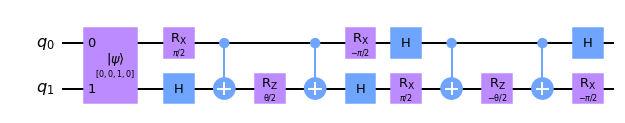

In [4]:
circuit = custom_ansatz(["+YX", "-XY"], 2, [0], [1], [0,0,1,0])
circuit.draw(output="mpl")

In [6]:
circuit.num_parameters

1

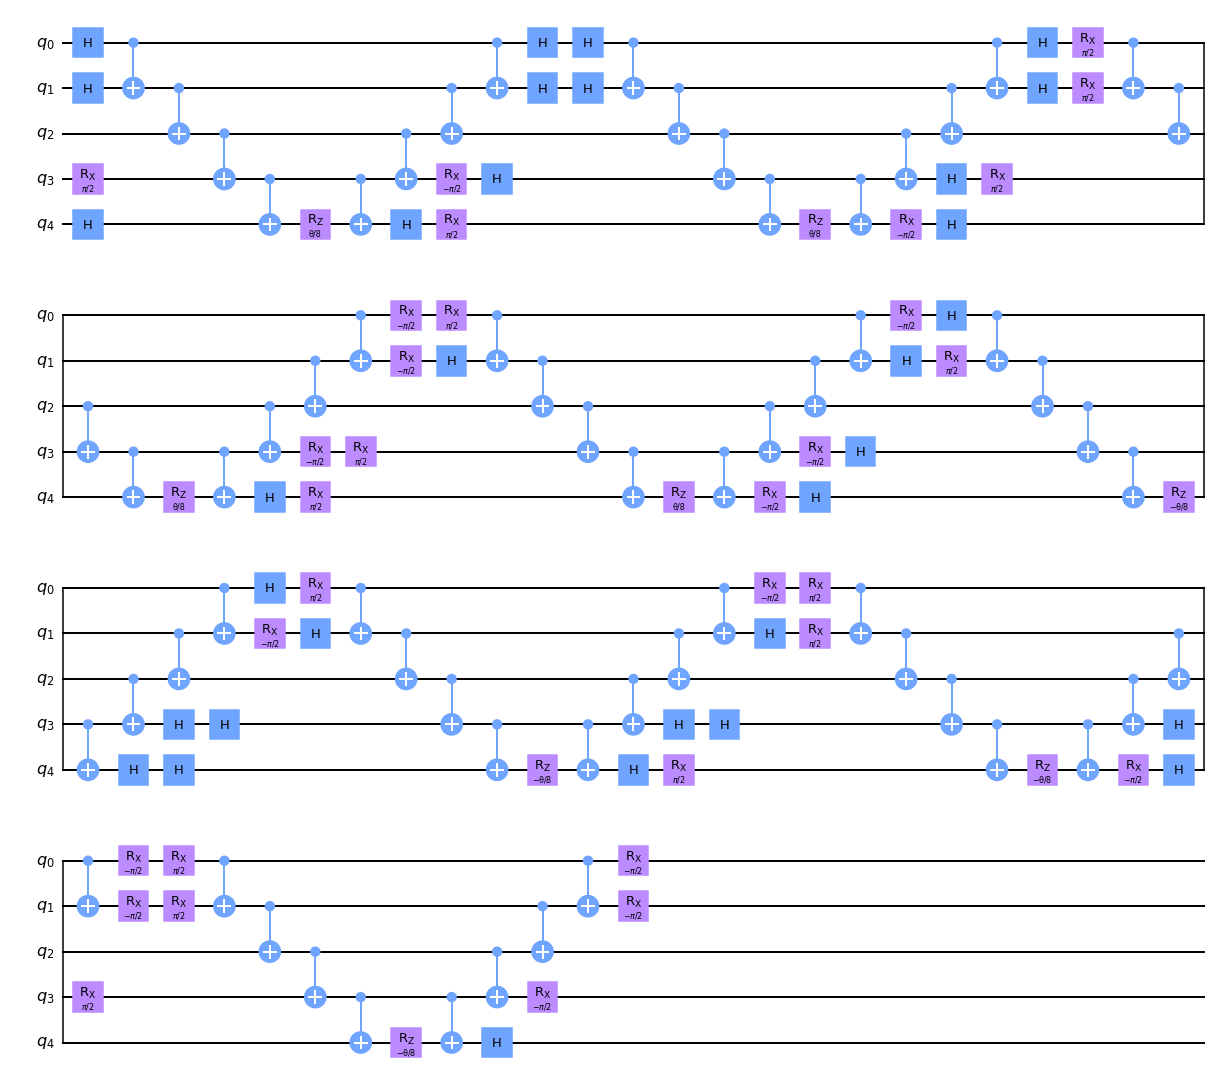

In [98]:
circuit = custom_ansatz(
    ["+XXYX", "+XXXY", "+YYYX", "+YXYY", "-XYXX", "-YXXX", "-YYXY", "-YYYX"],
    5, [0,1], [3,4], False)
circuit.draw(output="mpl")

# Examplary use of a custom ansatze

In [90]:
from qiskit_nature.second_q.drivers import PySCFDriver
driver = PySCFDriver(atom="H 0 0 0; H 0 0 7.5", basis="sto-3g")
mol = driver.run()

In [75]:
mol.num_spin_orbitals

4

In [91]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()

In [92]:
from qiskit_nature.second_q.circuit.library import HartreeFock

initial_state=HartreeFock( mol.num_spatial_orbitals, mol.num_particles, mapper)
initial_state.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

In [93]:
initial_state._bitstr

[True, False, True, False]

In [79]:
bitstr = "".join([str(int(q)) for q in initial_state._bitstr])
bitstr

'1010'

In [80]:
from qiskit.quantum_info import Statevector

reference_state = Statevector.from_label(bitstr)
reference_state

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))


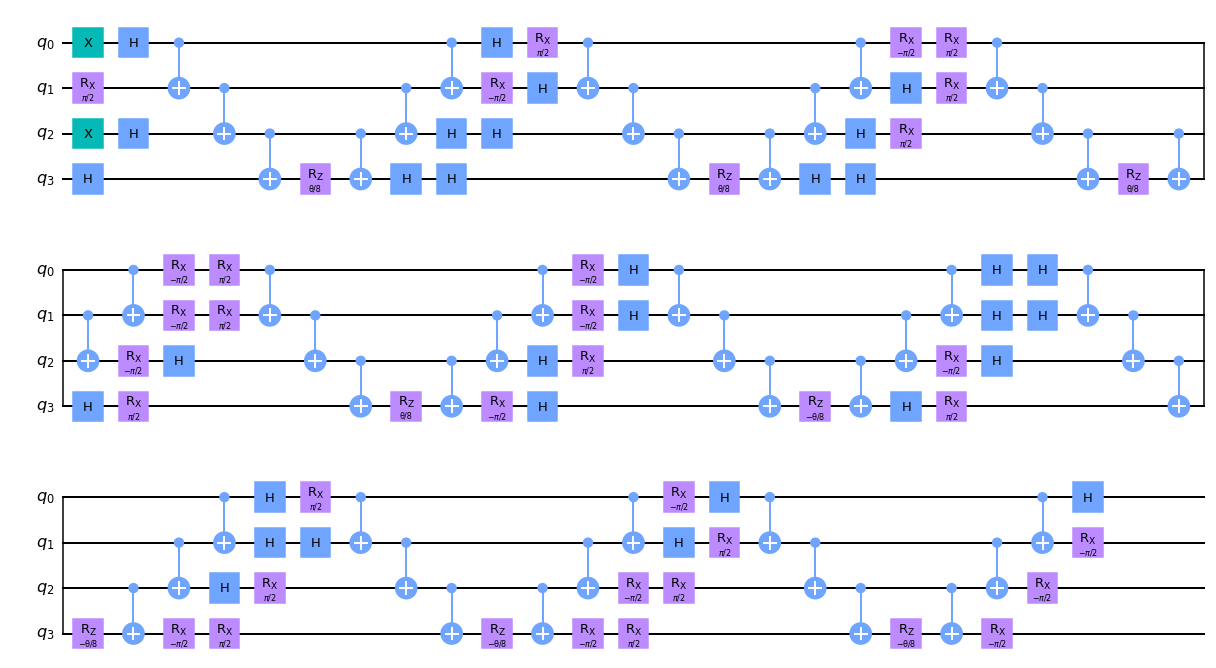

In [81]:
ansatz = custom_ansatz_2(
    ["+XYXX", "+YXXX", "+YYYX", "+YYXY", "-XXYX", "-XXXY", "-YXYY", "-XYYY"],
    mol.num_spin_orbitals, [0,1], [2,3], False)
ansatz.draw(output="mpl")

In [82]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
vqe = VQE(Estimator(), ansatz, SLSQP())

In [83]:
vqe.initial_point = np.zeros(ansatz.num_parameters)

In [84]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
solver = GroundStateEigensolver(mapper, vqe)
result = solver.solve(mol)

print(f"Total ground state energy = {result.total_energies[0]:.4f}")

Total ground state energy = -1.0430


# Qiskit

In [85]:
from qiskit_nature.second_q.drivers import PySCFDriver
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.5", basis="sto-3g")
problem = driver.run()

from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

import numpy as np
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
vqe = VQE(Estimator(), ansatz, SLSQP())

vqe.initial_point = np.zeros(ansatz.num_parameters)

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
solver = GroundStateEigensolver(mapper, vqe)
result = solver.solve(problem)

print(f"Total ground state energy = {result.total_energies[0]:.4f}")

Total ground state energy = -1.0552
